<a href="https://colab.research.google.com/github/thiagolermen/facemask-detection-v1/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detection

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing mask or not wearing them..
This dataset contains 853 images belonging to the 2 classes.
The classes are:

- With mask;
- Without mask;


##Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###Path to Kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/facemask-detection
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle/facemask-detection


##Dataset

In [ ]:
# Checking the file
!ls

with1.jpg  with3.jpeg  with_mask     without2.jpg  X_train.pickle
with2.jpg  with4.jpg   without1.jpg  without_mask  y_train.pickle


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
import pathlib

dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/"

mask_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/with_mask/"
mask_dir = pathlib.Path(mask_dir)

no_mask_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/without_mask/"
no_mask_dir = pathlib.Path(no_mask_dir)

classes = ["with_mask", "without_mask"]


Counting the number of files

In [ ]:
mask_count = len(list(mask_dir.glob('*.*')))
no_mask_count = len(list(no_mask_dir.glob('*.*')))
print(f"Number of images with mask: {mask_count} \nNumber of images without mask: {no_mask_count}")

Number of images with mask: 1884 
Number of images without mask: 1913


###Visualizing the dataset

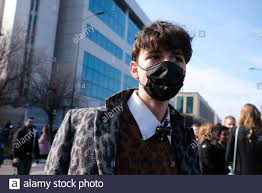

In [ ]:
mask = list(mask_dir.glob('*'))
PIL.Image.open(str(mask[0]))

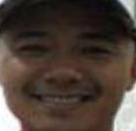

In [ ]:
no_mask = list(no_mask_dir.glob('*'))
PIL.Image.open(str(no_mask[0]))

##Creating training data

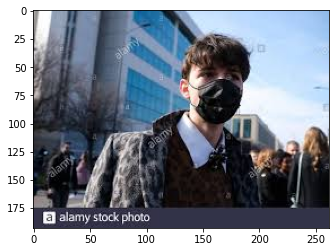

In [ ]:
for category in classes:
  path = os.path.join(dir, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show
    break
  break

###Preprocessing data

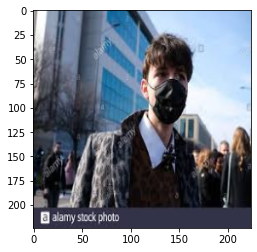

In [ ]:
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

####Reading the images and converting all to array

In [ ]:
training_data = [] # data

def create_training_data():
  for category in classes:
    path = os.path.join(dir, category)
    class_num = classes.index(category) # 0,1 -> labels
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num]) # [[img, label]]
      except Exception as e:
        pass

In [ ]:
create_training_data()

In [ ]:
print(f"Training data size: {len(training_data)}")

Training data size: 3797


In [ ]:
import random

random.shuffle(training_data)

In [ ]:
X_train = [] # data
y_train = [] # label

# Create a numpy array with all the features
for features, label in training_data:
  X_train.append(features)
  y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)

In [ ]:
X_train.shape

(3797, 224, 224, 3)

In [ ]:
# Normalize the data
X_train = X_train/255.0

In [ ]:
y_train = np.array(y_train)

In [ ]:
# Export data
#import pickle

#pickle_out = open("X_train.pickle", "wb")
#pickle.dump(X_train, pickle_out, protocol=4)
#pickle_out.close()

#pickle_out = open("y_train.pickle", "wb")
#pickle.dump(y_train, pickle_out, protocol=4)
#pickle_out.close()

In [ ]:
# Import data
# pickle_in = open("X_train.pickle", "rb")
# X_train = pickle.load(pickle_in)

# pickle_in = open("y_train.pickle", "rb")
# y_train = pickle.load(pickle_in)

##Creating the model

Pretrained model:

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

####Fine tuning

In [ ]:
base_input = model.layers[0].input # the model starts at the pretrained model's first layer

In [ ]:
base_output = model.layers[-4].output # cuts at the pretraining model's dropout layer

In [ ]:
flatten_layer = layers.Flatten()(base_input) # connect this layer with base_input
final_output = layers.Dense(1)(flatten_layer) # connect with flatten_layer
                                              # the model classifies in 1 or 0 (with or without mask)
final_output = layers.Activation('sigmoid')(final_output) # add an activation function to the dense layer

In [ ]:
new_model = keras.Model(inputs = base_input, outputs=final_output)

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 150529    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


##Compile the model

In [ ]:
new_model.compile(loss = "binary_crossentropy", 
                  optimizer="adam",
                  metrics = ["accuracy"])

##Training the model

In [ ]:
epochs = 20
history = new_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/20
95/95 [==============================] - 2s 20ms/step - loss: 3.9412 - accuracy: 0.6876 - val_loss: 0.5391 - val_accuracy: 0.8829
Epoch 2/20
95/95 [==============================] - 1s 14ms/step - loss: 1.1533 - accuracy: 0.8249 - val_loss: 0.6053 - val_accuracy: 0.9013
Epoch 3/20
95/95 [==============================] - 1s 14ms/step - loss: 0.5448 - accuracy: 0.8963 - val_loss: 0.5139 - val_accuracy: 0.9053
Epoch 4/20
95/95 [==============================] - 1s 15ms/step - loss: 0.6356 - accuracy: 0.8705 - val_loss: 0.4216 - val_accuracy: 0.9211
Epoch 5/20
95/95 [==============================] - 1s 15ms/step - loss: 0.3919 - accuracy: 0.9154 - val_loss: 0.5570 - val_accuracy: 0.9118
Epoch 6/20
95/95 [==============================] - 1s 16ms/step - loss: 0.4455 - accuracy: 0.9086 - val_loss: 0.7390 - val_accuracy: 0.8724
Epoch 7/20
95/95 [==============================] - 1s 14ms/step - loss: 1.6777 - accuracy: 0.8109 - val_loss: 1.5473 - val_accuracy: 0.8539
Epoch 8/20
95

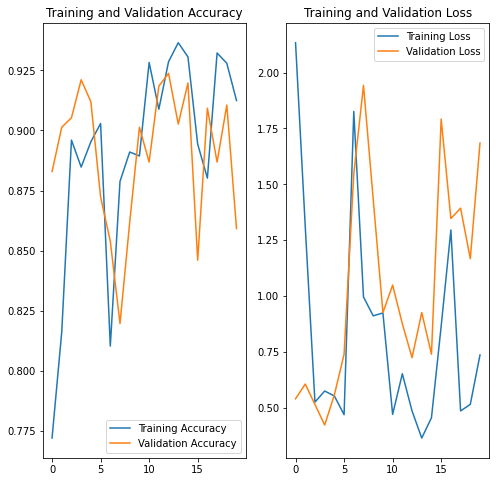

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Predictions

With mask


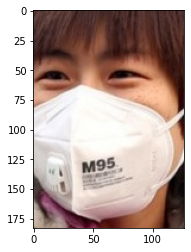

In [ ]:
frame = cv2.imread('with1.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

With mask


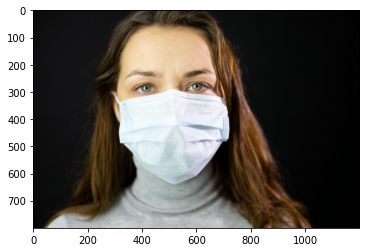

In [ ]:
frame = cv2.imread('with2.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

With mask


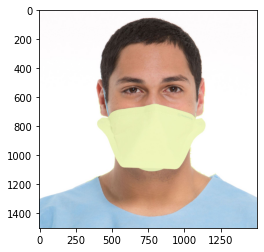

In [ ]:
frame = cv2.imread('with3.jpeg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

With mask


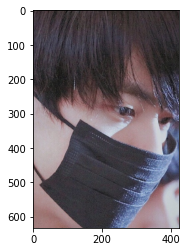

In [ ]:
frame = cv2.imread('with4.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

Without mask


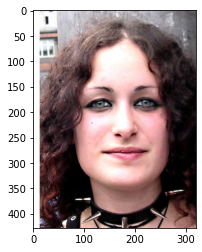

In [ ]:
frame = cv2.imread('without1.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

Without mask


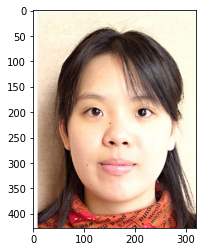

In [ ]:
frame = cv2.imread('without2.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

Without mask


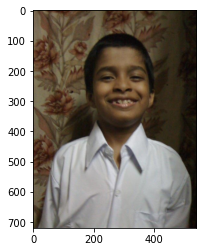

In [ ]:
frame = cv2.imread('without3.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

With mask


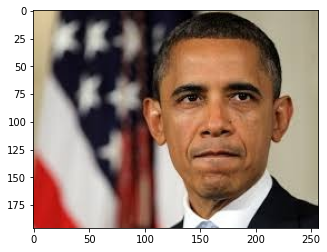

In [ ]:
frame = cv2.imread('without4.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

Without mask


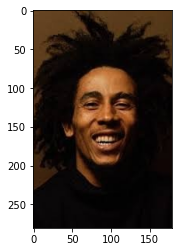

In [ ]:
frame = cv2.imread('without5.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")